Ideias:
- Minerar colaborações

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from unidecode import unidecode
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leomurta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leomurta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
#reads publications from Excel file
df = pd.read_excel('publications.xlsx', keep_default_na=False)
df.head()

,title,authors,institutions,venue,year
0,Towards Component-based Software Maintenance v...,Leonardo Murta; Hamilton Oliveira; Cristine Da...,COPPE/UFRJ,wmswm,2004
1,Documentacao Essencial para Manutencao de Soft...,Sérgio Cozzetti Bertoldi de Souza; Wesley Chri...,UCB,wmswm,2004
2,Evolução Orientada a Aspectos de um Framework OO,Maria Tânia Francelino da Silva; Rosana T. Vac...,USP,wmswm,2004
3,An Evolution Process for Application Frameworks,Maria Istela Cagnin; José Carlos Maldonado; Pa...,USP; UFSCar,wmswm,2004
4,Uma experiencia no ensino de manutencao de sof...,Márcio Greyck Batista Dias,UNIGOIÁS ANHANGUERA,wmswm,2004


# Authors

In [3]:
def first_last(text):
    words = text.split(' ')
    return f'{words[0]} {words[-1]}'

df['authors'].apply(unidecode).str.split('; ').explode().apply(first_last).value_counts().head(20)

Claudia Werner        18
Marco Valente         16
Leonardo Murta        10
Rosangela Penteado    10
Manoel Mendonca       10
Marcelo Schots        10
Marco                  8
Andre Hora             8
Marcelo Maia           7
Glauco Carneiro        7
Paulo Junior           6
Renato Novais          6
Claudio Sant'Anna      6
Eduardo Figueiredo     5
Marco Gerosa           5
Aline Vasconcelos      5
Ricardo Terra          5
Valter Camargo         5
Nicolas Anquetil       4
Igor Wiese             4
Name: authors, dtype: int64

# Institutions

In [4]:
df['institutions'].apply(unidecode).str.split('; ').explode().value_counts().head(20)

UFMG            34
COPPE/UFRJ      23
USP             23
UFBA            22
UFLA            13
UFSCar          13
IFBA            10
UNIFACS          9
UFMS             9
UFU              9
UFF              8
UFPA             7
UNIFOR           7
UTFPR            6
UFS              5
UFCG             4
PUC Minas        4
UCB              4
CEFET Campos     4
UFRGS            4
Name: institutions, dtype: int64

# Title bigrams

In [5]:
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# @TODO: unificar o idioma
# @TODO: unificar plural e singular (stemming)

title = df['title'].str.upper()\
                   .apply(unidecode)\
                   .apply(RegexpTokenizer(r'\w+').tokenize)\
                   .apply(lambda x: [word for word in x if word.lower() not in (stopwords.words('english') + stopwords.words('portuguese'))])
                   
bigrams = title.apply(lambda x: list(ngrams(x, 2))).explode().value_counts()
bigrams.head(20)


(MANUTENCAO, SOFTWARE)      14
(CODIGO, FONTE)              5
(SOFTWARE, EVOLUTION)        5
(ESTUDO, PRELIMINAR)         5
(ESTUDO, EMPIRICO)           4
(LARGA, ESCALA)              4
(ORIENTADOS, OBJETOS)        4
(PROJETOS, SOFTWARE)         4
(SISTEMAS, LEGADOS)          4
(EVOLUCAO, SOFTWARE)         4
(CASOS, USO)                 4
(PADROES, ARQUITETURAIS)     3
(ENGENHARIA, REVERSA)        3
(VISUALIZACAO, SOFTWARE)     3
(ENSINO, MANUTENCAO)         3
(ESCALA, SOBRE)              3
(ORIENTADO, OBJETOS)         3
(COMPREENSAO, PROGRAMAS)     3
(ESTUDO, LARGA)              3
(PRODUTOS, SOFTWARE)         3
Name: title, dtype: int64

<AxesSubplot: >

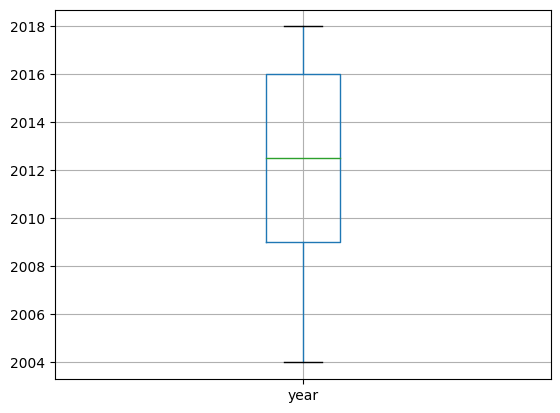

In [6]:
#plots the number of papers published per edition
#df.plot(kind='bar')
df.boxplot()

In [7]:
#df.to_excel('publications.xlsx', index=False)